In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mp
import pandas as pd
import numpy as np
import pysam
import pyranges as pr
%config InlineBackend.figure_format = 'retina'

In [2]:
# globally set font

import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# Add read_info to bam

Run the script `add_tag_to_bam.py` to add read_info tag to the bam file first.

The `read.info.txt` is generated by `merge_read_info.R`

In [ ]:
! python add_tag_to_bam.py -i cb2.sorted.bam -o cb2.sorted.tagged.bam --read_info cb2.read.info.txt

# Class for alignment visualization

In [3]:
# the representative gene_id is available at:
# https://www.arabidopsis.org/download_files/Genes/Araport11_genome_release/Araport11_blastsets/Araport11_seq_20160703_representative_gene_model.gz

araport11_isoform_path = 'genome_lib/araport11.representative.gene_model.bed'
araport11_isoform = pd.read_csv(araport11_isoform_path, sep='\t', 
                                names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                       'score', 'strand', 'thickStart', 'thickEnd', 
                                       'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
                               )
araport11_isoform['gene_id'] = araport11_isoform['name'].map(lambda x: x.split('.')[0])
araport11_isoform.set_index('gene_id', inplace=True)

In [25]:
class IGV(object):
    '''IGV(gene_id)
    
    A class for bam alignment visualization, base on the bam file and the annotation bed12 file

    Attributes:
        gene_id: A string type of gene_id list in bed12 file.
    '''

    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self.bam_list = {}

    def _set_plot_range(self, read, polya_len=0):
        if not read.is_reverse and self.max < read.reference_end+polya_len:
            self.max = read.reference_end+int(polya_len)
        elif read.is_reverse and self.min > read.reference_start-polya_len:
            self.min = read.reference_start-int(polya_len)

    def _get_gene_info(self):
        '''
        Get gene info from bed file
        '''
        gene_info = araport11_isoform.loc[self.gene_id]  # araport11_isoform loaded from pandas
        self.chrom = 'chr'+gene_info.chrom
        self.start = gene_info.chromStart
        self.end = gene_info.chromEnd
        self.strand = gene_info.strand
        self.thickStart = gene_info.thickStart
        self.thickEnd = gene_info.thickEnd
        self.blockCount = gene_info.blockCount
        self.strand_boo = False if self.strand == '+' else True
        self.blockSizes = np.fromstring(gene_info.blockSizes, sep=',', dtype='int')
        self.blockStarts = np.fromstring(gene_info.blockStarts, sep=',', dtype='int') + self.start # 0 base

    def _plot_gene_model(self, ax, gene_color='k'):
        # plot TSS
        small_relative = 0.05 * (self.max-self.min) 
        arrowprops = dict(arrowstyle="-|>", connectionstyle="angle", color=gene_color)
        if self.strand == '+':
            ax.annotate('', xy=(self.start+small_relative, .6), xytext=(self.start, 0), arrowprops=arrowprops)
        else:
            ax.annotate('', xy=(self.end-small_relative, .6), xytext=(self.end, 0), arrowprops=arrowprops)
        ax.plot([self.start, self.end], [0, 0], color=gene_color) 

        height = .3 # the height of gene model

        for exonstart, size in zip(self.blockStarts, self.blockSizes):
            if exonstart == self.start and exonstart+size == self.end:
                utr_size = self.thickStart-self.start
                utr = mp.Rectangle((exonstart, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                utr_size = self.end-self.thickEnd
                utr = mp.Rectangle((self.thickEnd, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                exon = mp.Rectangle((self.thickStart, 0-height), self.thickEnd-self.thickStart, height*2, color=gene_color, linewidth=0)
                ax.add_patch(exon)
            elif exonstart + size <= self.thickStart:
                # only 5'/ 3'UTR
                utr = mp.Rectangle((exonstart, 0-height/2), size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
            elif exonstart < self.thickStart and exonstart + size > self.thickStart:
                # exon with 5' / 3' UTR 
                utr_size = self.thickStart-exonstart
                utr = mp.Rectangle((exonstart, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                exon = mp.Rectangle((exonstart+utr_size, 0-height), size-utr_size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                ax.add_patch(exon)
            elif exonstart >= self.thickStart and exonstart + size <= self.thickEnd:
                # regular exon
                exon = mp.Rectangle((exonstart, 0-height), size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(exon)
            elif exonstart < self.thickEnd and exonstart + size > self.thickEnd:
                # exon with 3' / 5' UTR
                utr_size = exonstart + size - self.thickEnd
                utr = mp.Rectangle((self.thickEnd, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                exon = mp.Rectangle((exonstart, 0-height), size-utr_size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                ax.add_patch(exon)
            elif exonstart >= self.thickEnd:
                # only 3'/ 5'UTR
                utr = mp.Rectangle((exonstart, 0-height/2), size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
            
        ax.annotate(self.gene_id, xy=((self.start+self.end)/2, 0.8), ha='center')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_ticks_position('none')
        ax.set_ylim(-.5, 1)
        
        
    def _find_exon(self, read):
        BAM_CREF_SKIP = 3 #BAM_CREF_SKIP
        blockStart = []
        blockSize = []
        match_or_deletion = {0, 2, 7, 8} # only M/=/X (0/7/8) and D (2) are related to genome position
        exon_start = read.reference_start
        length = 0
        for op, nt in read.cigartuples:
            if op in match_or_deletion:
                length += nt
            elif op == BAM_CREF_SKIP:
                blockStart.append(exon_start)
                blockSize.append(length)
                exon_start += length+nt
                length = 0
        blockStart.append(exon_start)
        blockSize.append(length)
        return zip(blockStart, blockSize)
        
    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .6
        for read in read_list:
            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)
            # 画polya尾巴
            polya_len = read.get_tag('pa')
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.set_ylim(ypos-int(len(read_list)*.1), 1+int(len(read_list)*.25))
        
        if bam_num != len(self.bam_list):
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_ticks_position('none')
        else:
            ax.set_xlabel('Length (nt)')

    def _filter_reads(self, read, five_prime_threshold=150):
        # discard the antisense read
        if read.is_reverse is not self.strand_boo:
            return True
        # discard reads generated from upstream gene
        if read.is_reverse and read.reference_end-self.end > five_prime_threshold:
            return True
        elif not read.is_reverse and self.start - read.reference_start > five_prime_threshold:
            return True

        return False

    def _sort_bam(self, read_list, sort_method):
        if sort_method == '3':
            if self.strand == '+':
                read_list.sort(key=lambda read: read.reference_end)
            else:
                read_list.sort(key=lambda read: read.reference_start, reverse=True)
        elif sort_method == '5':
            if self.strand == '+':
                read_list.sort(key=lambda read: read.reference_start)
            else:
                read_list.sort(key=lambda read: read.reference_end, reverse=True)
        elif sort_method == 'ir':
            if self.strand == '+':
                read_list.sort(key=lambda read: read.get_tag('ri'))
            else:
                read_list.sort(key=lambda read: read.get_tag('ri'), reverse=True)

    def add_bam(self, *bam_paths, read_type={'polya', 'elongating'}, sort_method='3'):
        '''add_bam(self, *bam_paths, read_type={'polya', 'elongating'}, sort_method='3',)

        Add read object to the self.bam_list

        Args:
            *bam_paths: An the bam file path. default: {'polya', 'elongating'}.
            
            read_type: A set contained any of {'polya', 'elongating', 'elongating_5lost', 
                'polya_5lost', 'splicing_intermediate', 'elongating_3_mapping_low_accuracy', 
                'polya_3_not_in_last_exon'}
                Determines what kinds of reads to plot.
                
            sort_method: {'3', '5', 'ir'}, default '3'
                Sort reads strategy. -'3': sort by 3' end position of reads.
                -'5': sort by 5' end position of reads. 'ir': sort by retained
                intron.
        '''
        self.plot_polya = True
        for bam_path in bam_paths:
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                polya_read, non_polya_read = [], []
                
                # extend search range downstream 1000nt
                if self.strand == '-':
                    start = self.start-1000 if self.start > 1000 else 1
                    end = self.end
                else:
                    end = self.end+1000 if self.end+1000 < inbam.get_reference_length(self.chrom) else inbam.get_reference_length(self.chrom)
                    start = self.start
                    
                for read in inbam.fetch(self.chrom, start, end):
                    # filter read
                    if self._filter_reads(read):
                        continue
                    # get read info from bam tag
                    polya_len = read.get_tag('pa')
                    read_gene_id = read.get_tag('gi').split('.')[0]
                    
                    current_read_type = read.get_tag('ty')
                    if current_read_type not in read_type:
                        continue

                    if read_gene_id not in {gene_id, 'None'}:
                        continue
                    
                    if read.get_tag('ri') == 'None':
                        read.set_tag('ri', '')
                    
                    if polya_len > 15:
                        polya_read.append(read)
                        self._set_plot_range(read, polya_len)
                    elif polya_len < 15:
                        non_polya_read.append(read)
                        self._set_plot_range(read)
            # sort reads
            self._sort_bam(polya_read, sort_method)
            self._sort_bam(non_polya_read, sort_method)
            # merge
            non_polya_read.extend(polya_read)
            self.bam_list[bam_path] = non_polya_read

    def plot(self, height=3, width=6):
        '''plot(self, height=3, width=6)

        Plot the alignment

        Args:
            height: the height of the figure, default 3.
            width: the width of the figure, default 6.
        '''
        nrows = len(self.bam_list)+1
        height_ratios = [.6]
        for bam_path in self.bam_list:
                height_ratios.append(height)

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        if len(self.bam_list) == 0:
            self._plot_gene_model(ax)
        else:
            self._plot_gene_model(ax[0])

        # plot bam files
        for i, bam_path in enumerate(self.bam_list, 1):
            self._plot_bam(ax[i], self.bam_list[bam_path], i)
        
        ax_ = ax[i]
        step = (self.max-self.min)//400*100  # ticklabels of x_axis

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.min, self.max+step, step)
            ax_.set_xticks(xticks)
            ax_.set_xticklabels(xticks-self.min)
            ax_.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.max, self.min-step, -step)
            ax_.set_xticks(xticks)
            ax_.set_xticklabels(self.max-xticks)
            ax_.set_xlim(self.min, self.max)
            ax_.invert_xaxis()
            
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'{self.gene_id}.igv.svg', format='svg', bbox_inches='tight')

# elongating

../test_data/cb2.sorted.tagged.bam, n = 1276
../test_data/m64032_191128_003852.sorted.tagged.bam, n = 106
CPU times: user 9.28 s, sys: 6.56 ms, total: 9.29 s
Wall time: 9.29 s


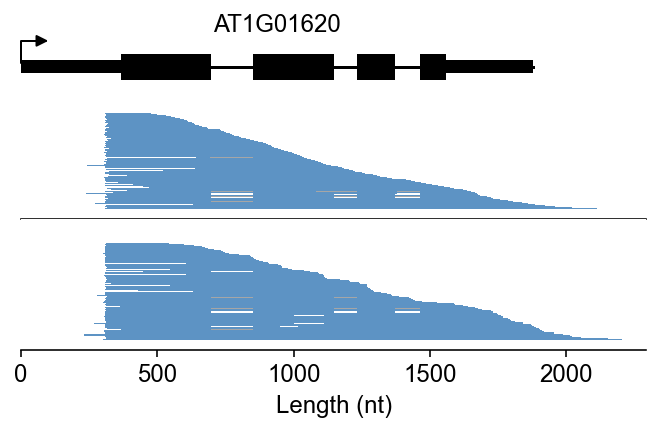

In [32]:
%%time

gene_id = 'AT1G01620'
nanopore_bam_file = 'nanopore.clean.bam'
pacbio_bam_file = 'pacbio.clean.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore_bam_file, pacbio_bam_file, read_type={'elongating'})
igv.plot(height=1.2, width=5.6)

for bam_path, bam_list in igv.bam_list.items():
    print(f'{bam_path}, n = {len(bam_list)}')

# polyadenylation

../test_data/cb2.sorted.tagged.bam, n = 203
../test_data/m64032_191128_003852.sorted.tagged.bam, n = 26
CPU times: user 3.12 s, sys: 4.85 ms, total: 3.13 s
Wall time: 3.13 s


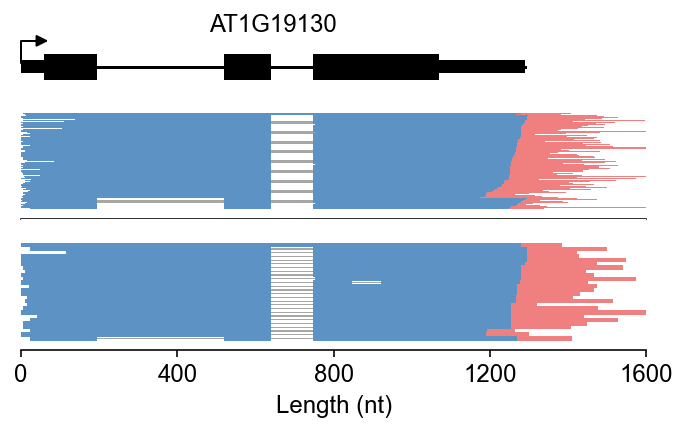

In [33]:
%%time

gene_id = 'AT1G19130'
nanopore_bam_file = 'nanopore.clean.bam'
pacbio_bam_file = 'pacbio.clean.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore_bam_file, pacbio_bam_file, read_type={'polya'}, sort_method='ir')
igv.min = igv.max-1600
igv.plot(height=1.2, width=5.6)

for bam_path, bam_list in igv.bam_list.items():
    print(f'{bam_path}, n = {len(bam_list)}')

# alternative polyadenylation

../test_data/cb2.sorted.tagged.bam, n = 327
../test_data/m64032_191128_003852.sorted.tagged.bam, n = 38
CPU times: user 13.7 s, sys: 17.5 ms, total: 13.7 s
Wall time: 13.7 s


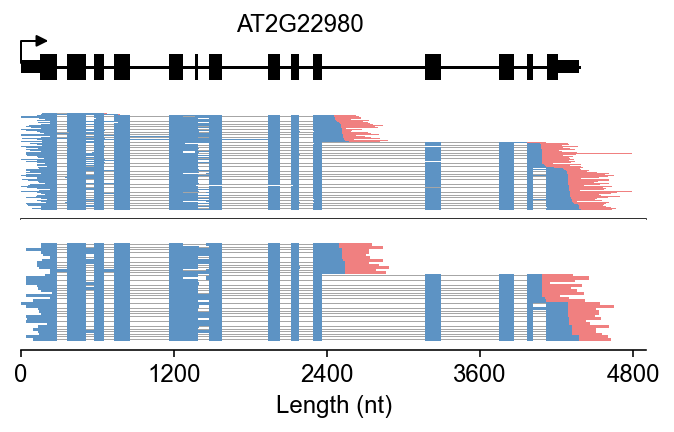

In [34]:
%%time

gene_id = 'AT2G22980'
nanopore_bam_file = 'nanopore.clean.bam'
pacbio_bam_file = 'pacbio.clean.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore_bam_file, pacbio_bam_file, read_type={'polya', 'polya_3_not_in_last_exon'})
igv.plot(height=1.2, width=5.6)

for bam_path, bam_list in igv.bam_list.items():
    print(f'{bam_path}, n = {len(bam_list)}')